In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid', {"axes.facecolor": ".96"})

import missingno as msno

In [2]:
df = pd.read_csv('fraud_df.csv')
print(df.shape)
print()
df.head()

(4156, 29)



,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,...,rep_loan_date_day,rep_loan_date_weekday,first_loan_year,first_loan_month,first_loan_day,first_loan_weekday,first_overdue_date_year,first_overdue_date_month,first_overdue_date_day,first_overdue_date_weekday
0,1.0,0.0,0.0,0.0,6,0,0,6,0,0,...,26,2,2015,9,28,1,2016.0,1.0,30.0,2
1,NaN,NaN,NaN,2.0,1,0,0,0,5,0,...,30,3,2015,12,21,1,NaN,NaN,NaN,-1
2,NaN,NaN,NaN,1.0,6,0,0,4,0,0,...,29,6,2015,6,30,5,NaN,NaN,NaN,-1
3,NaN,NaN,NaN,0.0,5,0,3,0,0,0,...,1,5,2015,8,3,1,NaN,NaN,NaN,-1
4,NaN,NaN,NaN,2.0,3,0,0,6,0,0,...,1,2,2015,8,30,3,NaN,NaN,NaN,-1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dpd_5_cnt                   675 non-null    float64
 1   dpd_15_cnt                  675 non-null    float64
 2   dpd_30_cnt                  675 non-null    float64
 3   close_loans_cnt             4141 non-null   float64
 4   federal_district_nm         4156 non-null   int64  
 5   payment_type_0              4156 non-null   int64  
 6   payment_type_1              4156 non-null   int64  
 7   payment_type_2              4156 non-null   int64  
 8   payment_type_3              4156 non-null   int64  
 9   payment_type_4              4156 non-null   int64  
 10  payment_type_5              4156 non-null   int64  
 11  past_billings_cnt           3908 non-null   float64
 12  score_1                     3507 non-null   float64
 13  score_2                     239 n

<Axes: >

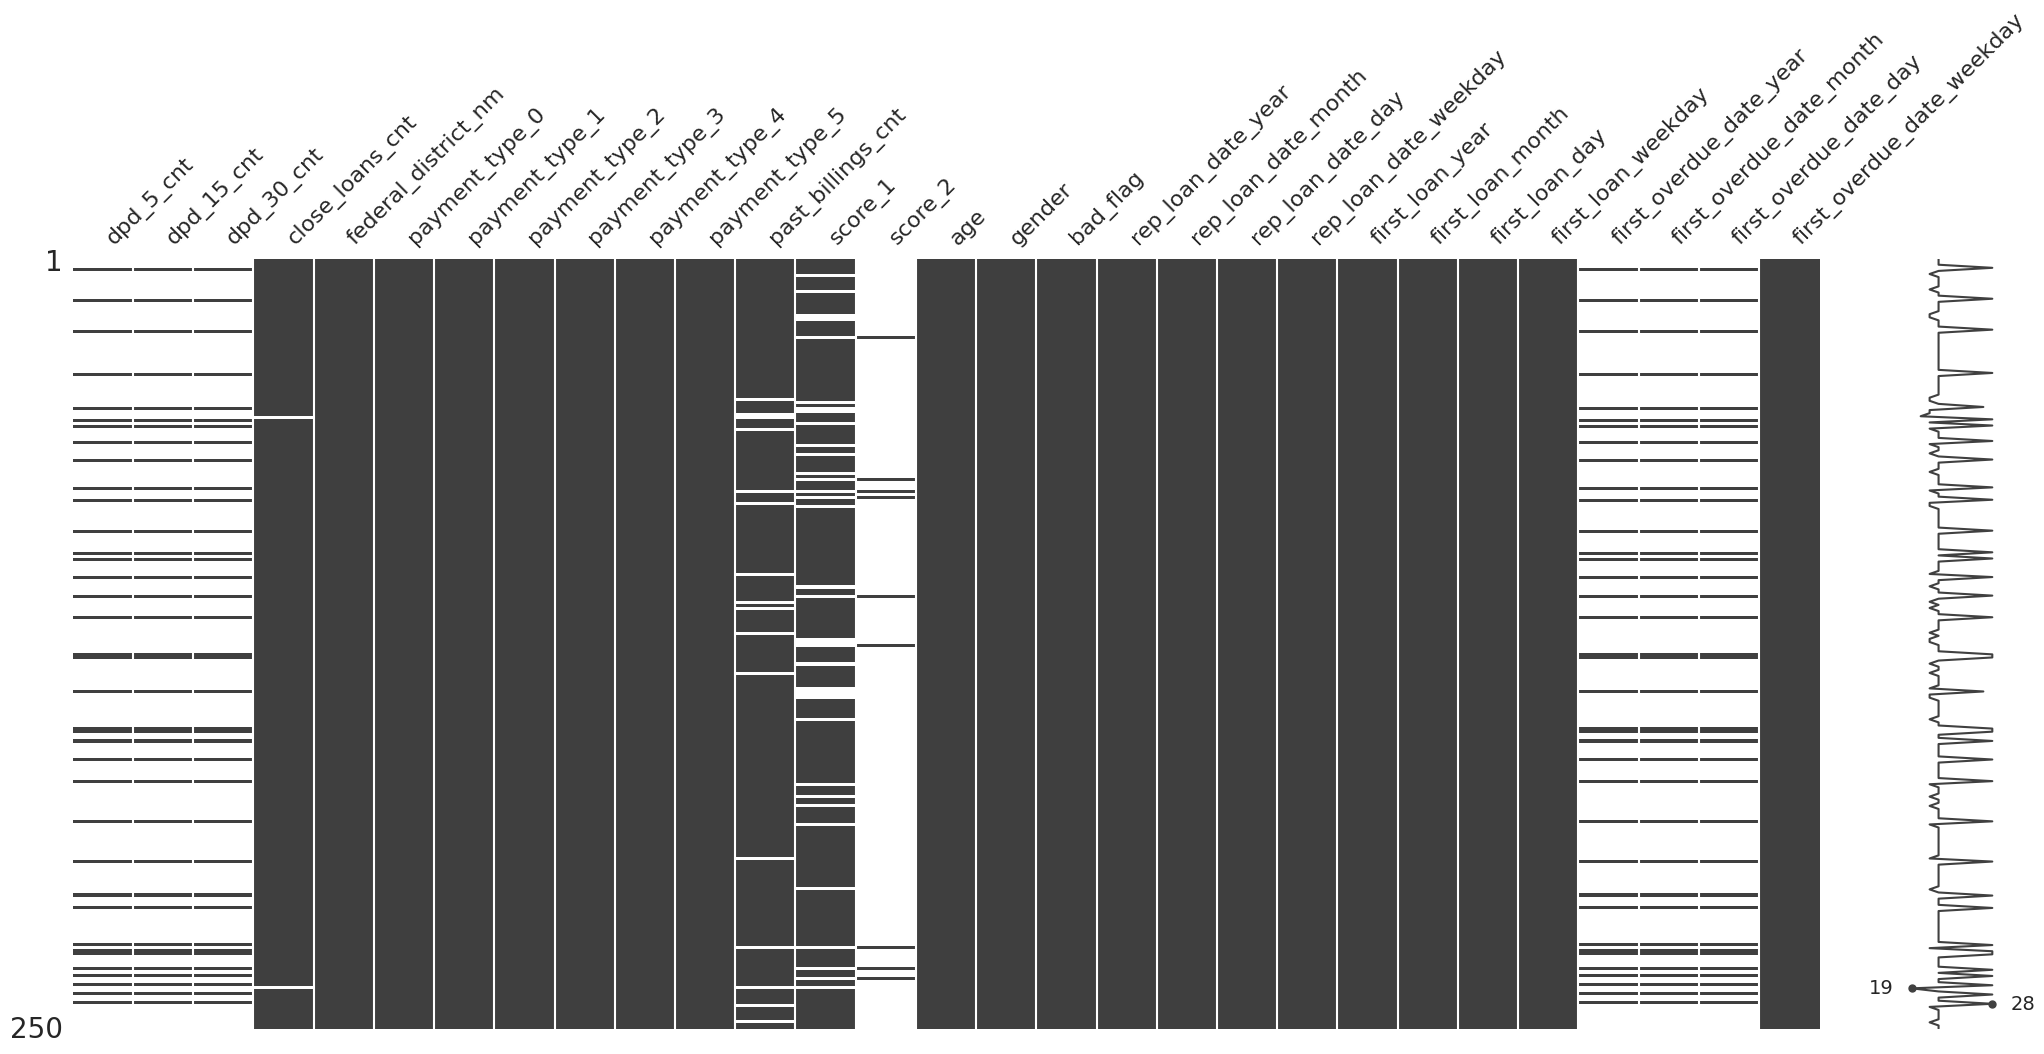

In [4]:
msno.matrix(df.sample(250))

Score_2 is the sparsest column. With only 239 non-null values it is a candidate to drop. However, the matrix indicates that those non-null 239 values are placed exactly where score_1 has a null value.

In [5]:
condition = df.loc[df['score_2'].notna(), 'score_1'].isna().all()
print("Every non-null score_2 corresponds to null in score_1:", condition)

Every non-null score_2 corresponds to null in score_1: True


In [6]:
df[['score_1', 'score_2']].describe()

,score_1,score_2
count,3507.000000,239.000000
mean,578.911345,552.546610
std,48.989869,21.492840
min,384.220628,485.874267
25%,547.429791,535.545724
50%,588.531315,556.757944
75%,612.323090,567.608057
max,691.528420,603.311653


The scores are in the roughly same scale, lets join them.

In [7]:
df['score_combined'] = df['score_1'].fillna(df['score_2'])
df = df.drop(columns=['score_1', 'score_2'])

In [8]:
df.score_combined.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4156 entries, 0 to 4155
Series name: score_combined
Non-Null Count  Dtype  
--------------  -----  
3746 non-null   float64
dtypes: float64(1)
memory usage: 32.6 KB


<Axes: >

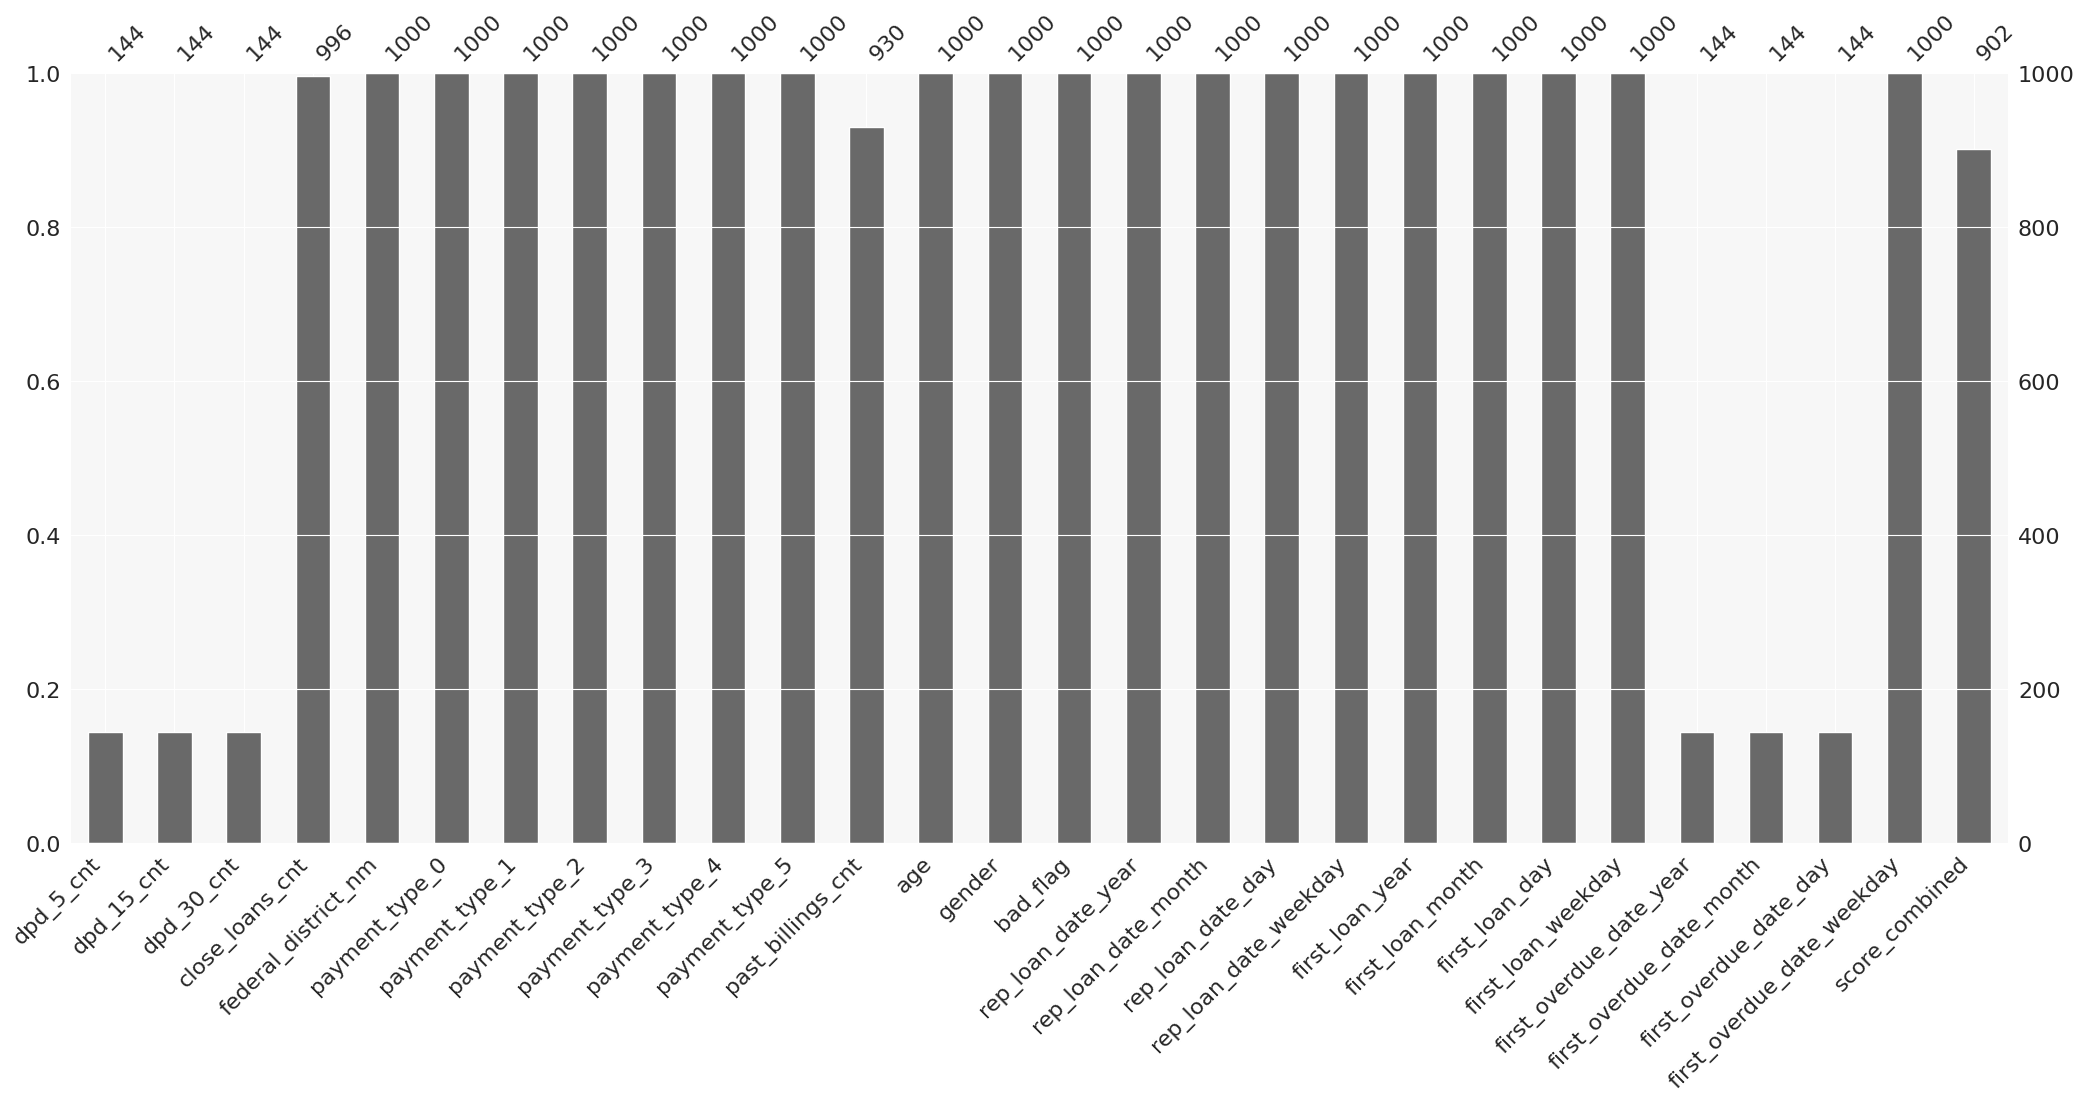

In [9]:
msno.bar(df.sample(1000))

In [10]:
df['dpd_5_cnt'].isna().sum()

np.int64(3481)

In [11]:
df.bad_flag.unique()

array([0, 1])

In [12]:
# 
df.groupby('bad_flag')[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].mean()


,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt
bad_flag,,,
0,1.414365,0.705341,0.265193
1,1.568182,0.848485,0.340909


In [13]:
sparse = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'first_overdue_date_year',
       'first_overdue_date_month', 'first_overdue_date_day']

for s in sparse:
      a = df.groupby(df[s].isna())["bad_flag"].mean()
      print(a)
      print()

dpd_5_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

dpd_15_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

dpd_30_cnt
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_year
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_month
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64

first_overdue_date_day
False    0.195556
True     0.081873
Name: bad_flag, dtype: float64



Sparse columns hold information about customers with an overdue history. Rows where the value is not NaN are more than twice as likely to be fraudulent as those where the value is missing.
Thus, the mere presence or absence of a value (NaN vs. non-NaN) carries information about the risk of fraud. Dripping NaN rows or sparse columns aret thus a  bad strategy for this dataset.

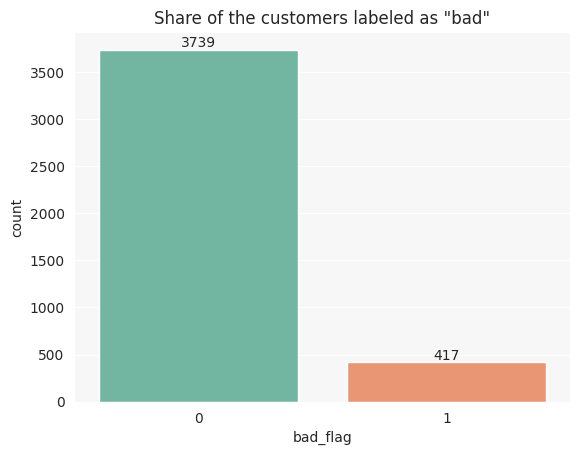

In [14]:
ax = sns.countplot(data=df,
                   x='bad_flag', 
                   hue='bad_flag',
                   palette='Set2',
                   legend=False)

plt.title('Share of the customers labeled as "bad"')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [15]:
df['has_overdue_info'] = df['first_overdue_date_year'].notna().astype(int)
df.drop(columns=[
    'first_overdue_date_year',
    'first_overdue_date_month',
    'first_overdue_date_day',
    'first_overdue_date_weekday'
], inplace=True)

The overdue date columns only add noise and complexity to the dataset, so I replaced them with a simple flag indicating whether any overdue information is present.

In [16]:
drop_cols = [
    # leakage
    'rep_loan_date_year',
    'rep_loan_date_month',
    'rep_loan_date_day',
    'rep_loan_date_weekday',

    # noise
    'first_loan_month',
    'first_loan_day',
    'first_loan_weekday',
]

df = df.drop(columns=drop_cols, errors='ignore')

In [17]:
df.head()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,age,gender,bad_flag,first_loan_year,score_combined,has_overdue_info
0,1.0,0.0,0.0,0.0,6,0,0,6,0,0,0,5.0,20,0,0,2015,NaN,1
1,NaN,NaN,NaN,2.0,1,0,0,0,5,0,0,5.0,19,0,0,2015,NaN,0
2,NaN,NaN,NaN,1.0,6,0,0,4,0,0,0,6.0,21,0,0,2015,NaN,0
3,NaN,NaN,NaN,0.0,5,0,3,0,0,0,0,3.0,33,0,0,2015,NaN,0
4,NaN,NaN,NaN,2.0,3,0,0,6,0,0,0,5.0,34,0,0,2015,NaN,0


### Handling Missing Values – Strategy Comparison

| Strategy | Advantages | Disadvantages | Recommendation for This Case |
|-----------|-------------|----------------|-------------------------------|
| **Drop NaN rows** | Simple, results in a clean dataset | Lose ~80% of the data → massive information loss; model would be biased (trained only on “bad” cases) | ❌ Very unsuitable |
| **Impute (e.g., 0, median)** | Works for models that cannot handle NaNs | Here, 0 has no meaning (0 ≠ date), adds noise → “artificial history” | 🚫 Worse than flagging |
| **Flag NaN (add `has_overdue` feature)** | Keeps the information that “NaN exists” | For most clients (= 0) it may be almost constant, but combined with other features it can still be valuable | ✅ Acceptable choice |
| **Keep NaN and use a model that supports it (CatBoost, XGBoost, LightGBM)** | No imputation needed; model internally splits on missingness | Requires compatible algorithms; interpretability of NaN handling can be tricky | ✅ Strong choice for tree-based models |


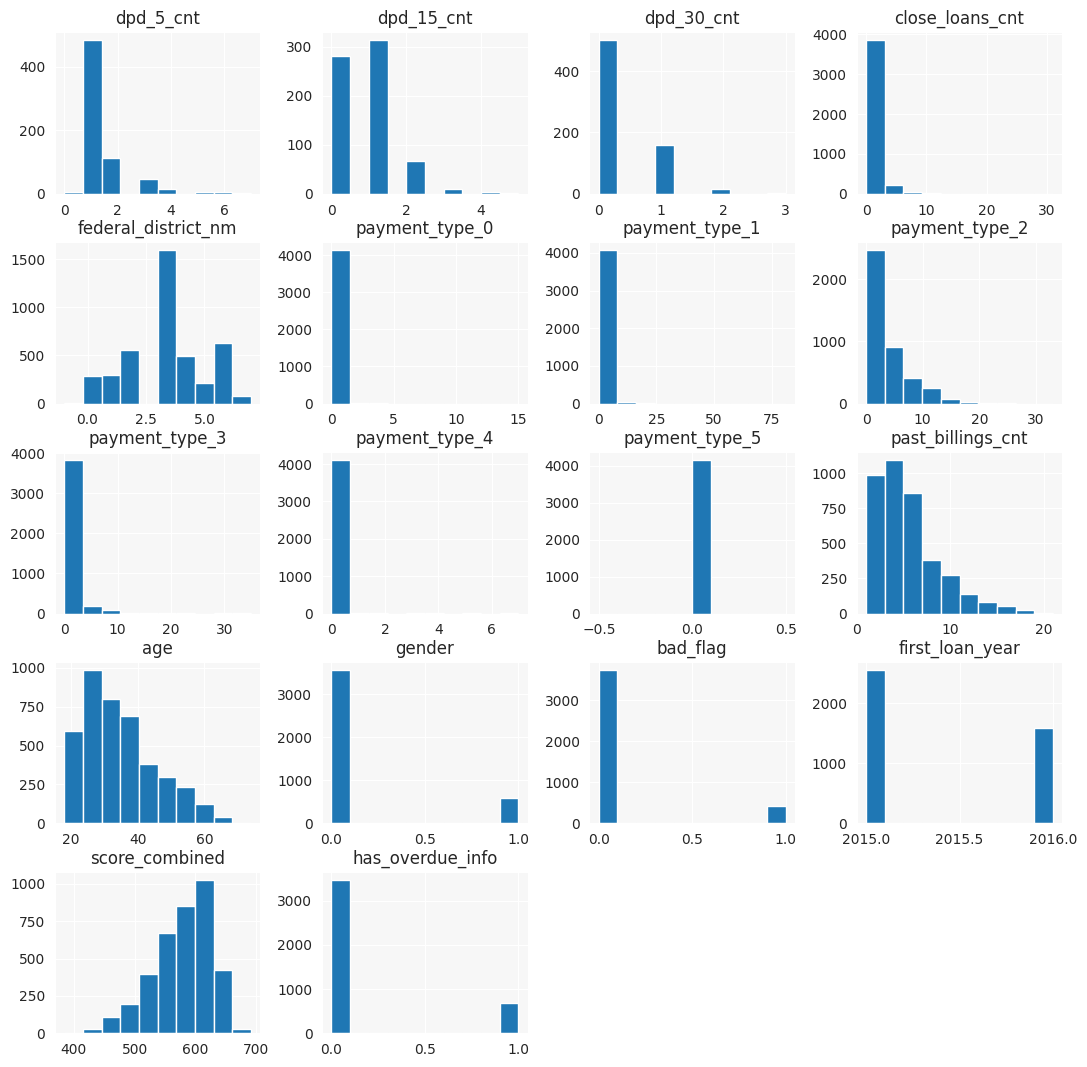

In [18]:
df.hist(figsize=(13,13))
plt.show()

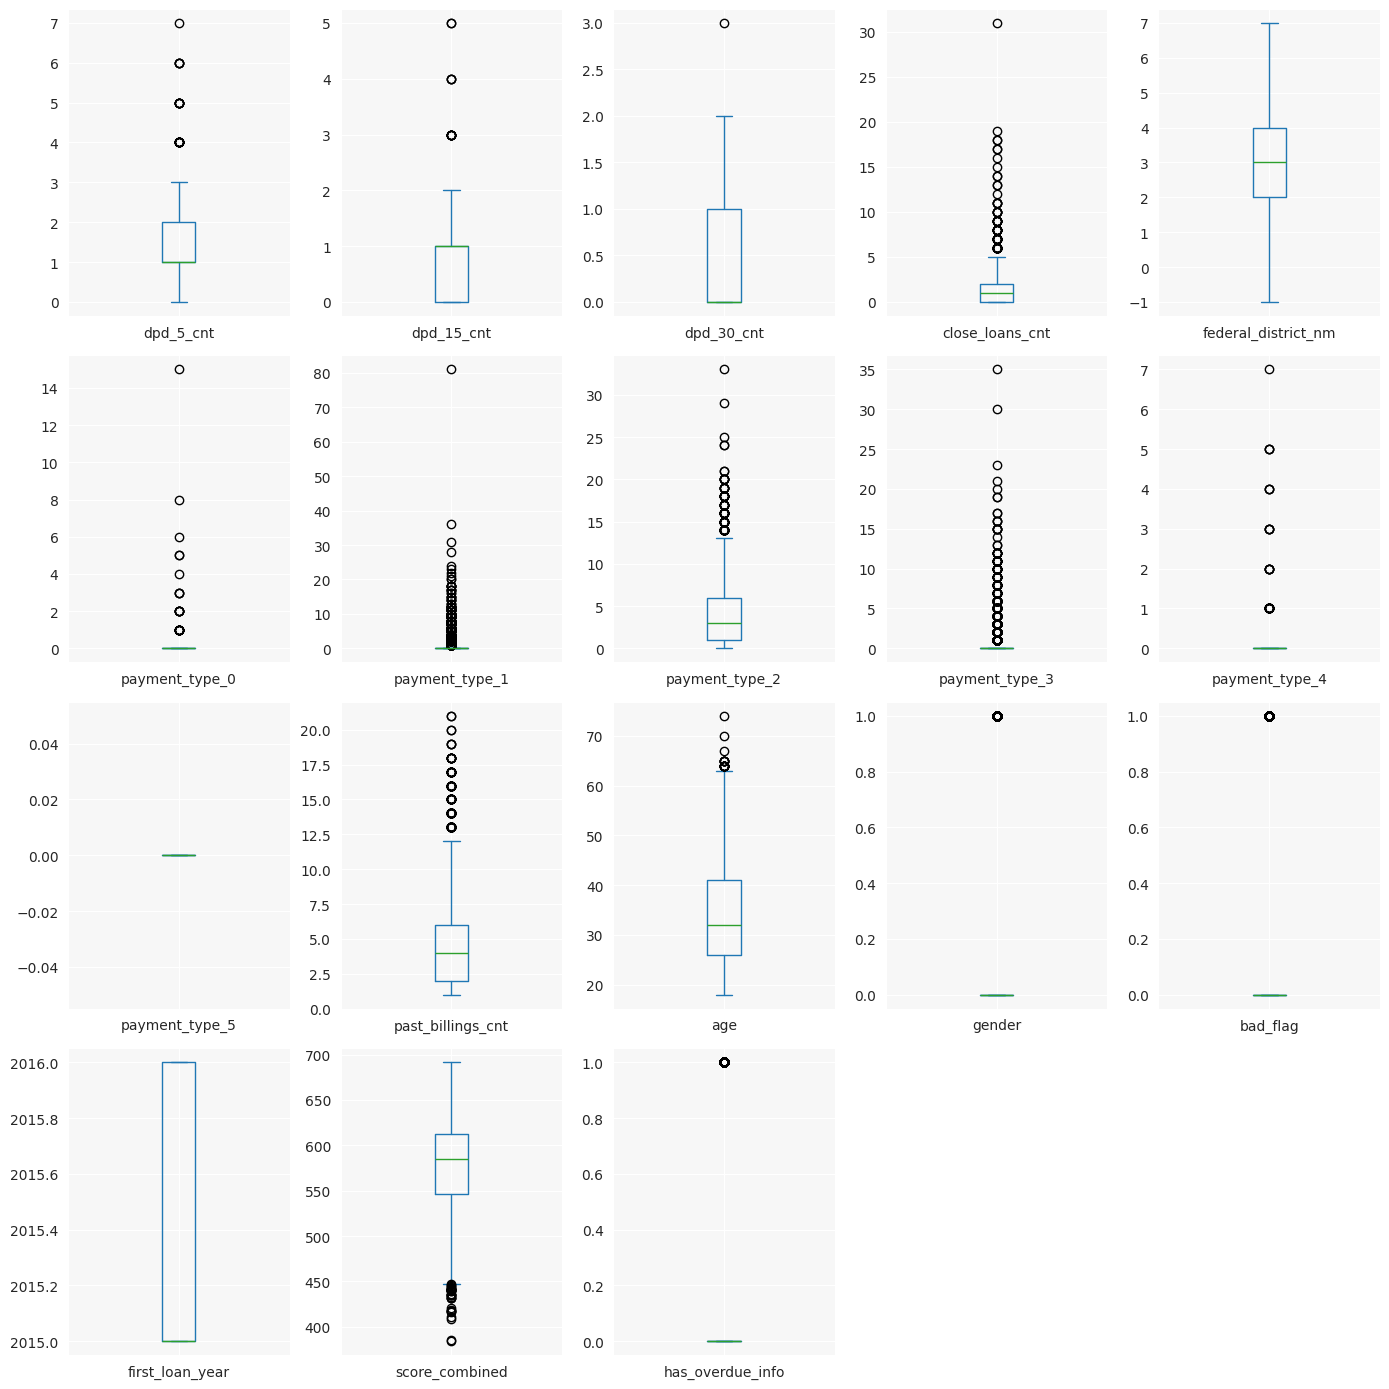

In [19]:
df.plot(kind='box', figsize=(14,14), subplots=True, layout=(4,5),
             sharex=False, sharey=False)
plt.tight_layout()  
plt.show()

In [20]:
sparse_info = pd.DataFrame({
    "dominant_share": df.apply(lambda x: x.value_counts(normalize=True, dropna=False).iloc[0]
                               if x.notna().sum() > 0 else np.nan)
}).sort_values(by="dominant_share", ascending=False)


print(sparse_info)

                     dominant_share
payment_type_5             1.000000
payment_type_0             0.993263
payment_type_4             0.990135
bad_flag                   0.899663
payment_type_1             0.874639
gender                     0.858758
dpd_15_cnt                 0.837584
dpd_5_cnt                  0.837584
has_overdue_info           0.837584
dpd_30_cnt                 0.837584
payment_type_3             0.806304
first_loan_year            0.616218
close_loans_cnt            0.402310
federal_district_nm        0.383782
payment_type_2             0.214389
past_billings_cnt          0.194177
score_combined             0.098653
age                        0.045717


In [21]:
df.drop(['payment_type_5','payment_type_4','payment_type_0'], axis=1, inplace=True)

The dataset is of unknown origin and lacks documentation. Therefore, the relationship between the credit score and `bad_flag` is unclear. If `bad_flag` is directly or indirectly derived from the score (or vice versa), it could cause data leakage.

Check the relationship:

In [22]:
df.groupby('bad_flag')['score_combined'].describe()

,count,mean,std,min,25%,50%,75%,max
bad_flag,,,,,,,,
0,3414.0,581.431631,45.454059,385.181110,552.861759,588.420530,612.364712,691.528420
1,332.0,534.015480,53.520111,384.220628,495.805064,533.910428,572.936126,682.760226


The test proves a clear relationship between `bad_flag` and `score_combined`. However, it is still unclear where this relationship comes from. Rather than dropping `score_combined` immediately, I decided to split the dataset and test the results both with and without the score variable.

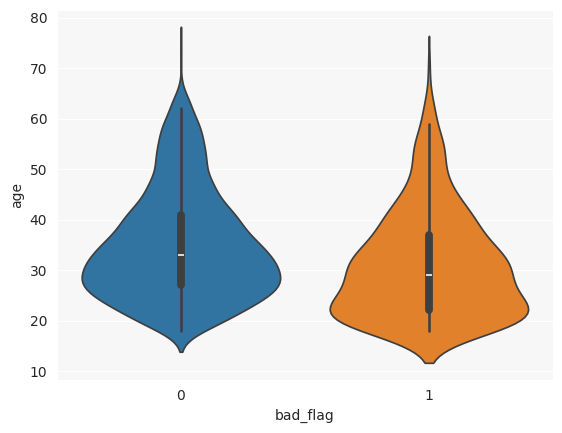

In [23]:
sns.violinplot(x='bad_flag', y='age', data=df, hue='bad_flag', legend=False)
plt.show()

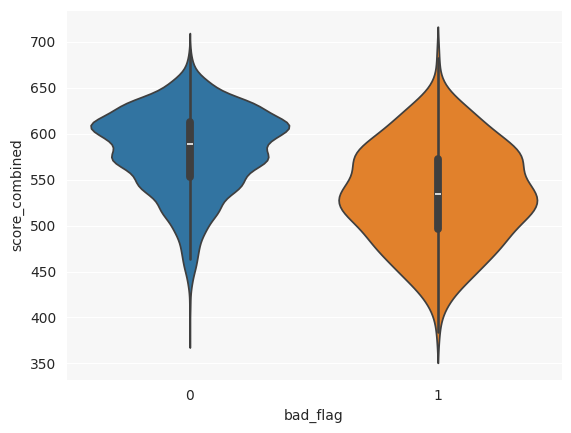

In [24]:
sns.violinplot(x='bad_flag', y='score_combined', data=df, hue='bad_flag', legend=False)
plt.show()

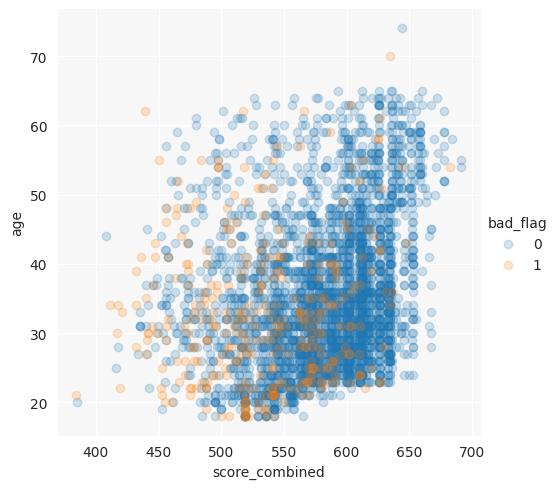

In [25]:
sns.lmplot(x='score_combined',
           y='age',
           hue='bad_flag',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.2})
plt.show()

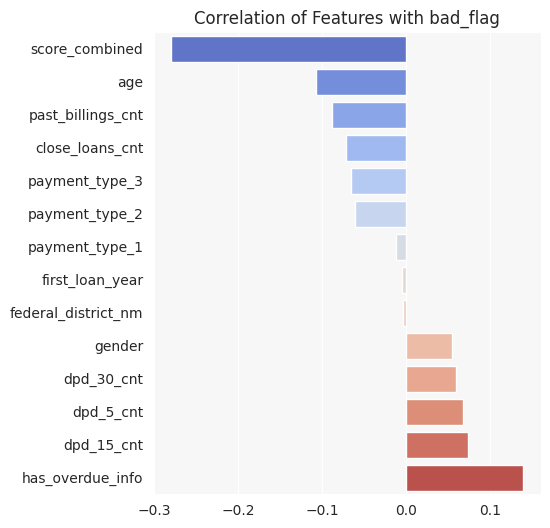

In [26]:
fig, ax = plt.subplots(figsize=(5, 6))

target_corr = df.corr()['bad_flag'].drop('bad_flag')  
target_corr_sorted = target_corr.sort_values()

sns.barplot(
    x=target_corr_sorted.values,
    y=target_corr_sorted.index,
    palette=sns.color_palette("coolwarm", len(target_corr_sorted)),
    hue=target_corr_sorted.index                         
)

ax.set_title('Correlation of Features with bad_flag')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

In [27]:
df.drop(['first_loan_year','federal_district_nm'], axis=1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dpd_5_cnt          675 non-null    float64
 1   dpd_15_cnt         675 non-null    float64
 2   dpd_30_cnt         675 non-null    float64
 3   close_loans_cnt    4141 non-null   float64
 4   payment_type_1     4156 non-null   int64  
 5   payment_type_2     4156 non-null   int64  
 6   payment_type_3     4156 non-null   int64  
 7   past_billings_cnt  3908 non-null   float64
 8   age                4156 non-null   int64  
 9   gender             4156 non-null   int64  
 10  bad_flag           4156 non-null   int64  
 11  score_combined     3746 non-null   float64
 12  has_overdue_info   4156 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 422.2 KB
